In [40]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm

In [5]:
master = DataMaster()

In [16]:
universe = master.baskets.get_index_historical_components('GSPC')


In [13]:
sectors = pd.read_parquet('sectors_sp500.pq')
sectors

,sector,industry,gicsect,gicgrp,gicind,gicsubind
A,Healthcare,Diagnostics & Research,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Life Sciences Tools & Services,Life Sciences Tools & Services
AA,Basic Materials,Aluminum,Materials,Materials,Metals & Mining,Aluminum
AABA,Other,Other,Consumer Discretionary,Retailing,Internet & Direct Marketing Retail,Internet & Direct Marketing Retail
AAL,Industrials,Airlines,Industrials,Transportation,Airlines,Airlines
AAP,Consumer Cyclical,Specialty Retail,Consumer Discretionary,Retailing,Specialty Retail,Automotive Retail
...,...,...,...,...,...,...
YUM,Consumer Cyclical,Restaurants,Consumer Discretionary,Consumer Services,"Hotels, Restaurants & Leisure",Restaurants
ZBH,Healthcare,Medical Devices,Health Care,Health Care Equipment & Services,Health Care Equipment & Supplies,Health Care Equipment
ZBRA,Technology,Communication Equipment,Information Technology,Technology Hardware & Equipment,"Electronic Equipment, Instruments & Components",Electronic Equipment & Instruments
ZION,Financial Services,Banks-Regional,Financials,Banks,Banks,Regional Banks


In [26]:
market_data = pd.read_parquet('sp500_mkt_data.pq')
balance_sheet = pd.read_parquet('balance_sheets_sp500.pq')

In [43]:
P = func.presence_matrix(universe)
P

Code,A,AA,AABA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABK,...,XRAY,XRX,XTO,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZTS
2000-01-03,True,True,False,False,False,True,False,False,False,False,...,False,True,True,False,True,True,False,False,False,False
2000-01-04,True,True,False,False,False,True,False,False,False,False,...,False,True,True,False,True,True,False,False,False,False
2000-01-05,True,True,False,False,False,True,False,False,False,False,...,False,True,True,False,True,True,False,False,False,False
2000-01-06,True,True,False,False,False,True,False,False,False,False,...,False,True,True,False,True,True,False,False,False,False
2000-01-07,True,True,False,False,False,True,False,False,False,False,...,False,True,True,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-15,True,False,False,True,True,True,True,True,False,False,...,True,True,False,True,False,True,True,True,True,True
2023-03-16,True,False,False,True,True,True,True,True,False,False,...,True,True,False,True,False,True,True,True,True,True
2023-03-17,True,False,False,True,True,True,True,True,False,False,...,True,True,False,True,False,True,True,True,True,True
2023-03-18,True,False,False,True,True,True,True,True,False,False,...,True,True,False,True,False,True,True,True,True,True


In [44]:
metrics = (-balance_sheet['netDebt'].astype(float)/balance_sheet['cash'].astype(float))
netdebt = metrics.unstack().ffill()
netdebt = netdebt.rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
netdebt.index = pd.to_datetime(netdebt.index)
netdebt = netdebt.stack().groupby(level=1).rolling(10).rank(pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).droplevel(0)
netdebt = netdebt.unstack().reindex_like(P).ffill()
netdebt.stack()



            Code
2000-01-31  AAL     0.524401
            AAPL   -0.524401
            ABC    -1.281552
            ABMD   -1.281552
            ABT     0.841621
                      ...   
2023-03-19  YUM    -1.281552
            ZBH     0.000000
            ZBRA    0.674490
            ZION    0.253347
            ZTS     1.644854
Length: 4946724, dtype: float64

In [81]:
GICS = sectors['gicsect'].fillna('Other')
R = market_data['close'].unstack().pct_change().clip(-1,1)

In [82]:
def center(x):
    mean = x.mean(1)
    x = x.sub(mean,0)
    return x

In [85]:

thresh =0.1
SIGNAL = netdebt.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None

SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\1665728516.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)


1.499849205618199


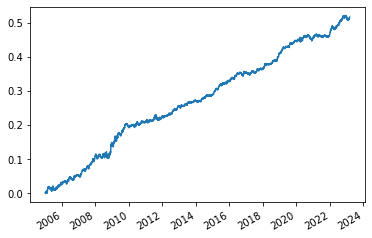

In [86]:
pnl = (SIGNAL.shift(1) *R).sum(1).replace({0:np.nan}).dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()
plt.show()

SIGNAL LOW / CLOSE

In [195]:
metrics = pd.DataFrame(market_data['low'].divide(market_data['close']),dtype=float)
metrics.columns =['metrics']
metrics= metrics['metrics'].unstack().diff(26)
metrics = metrics[P].rank(1,pct=True,ascending=False).clip(0.01,0.99)
# metrics = metrics.stack().groupby(level=1).rolling(10).rank(pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).droplevel(0)

# metrics = metrics.rolling(10).rank(axis=0,pct=True,asceneing=True)


In [196]:

thresh =0.25
SIGNAL = metrics.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None

SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\702060786.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)


-1.162540367664539


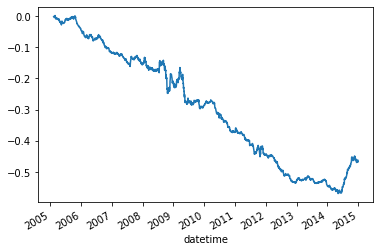

In [198]:
pnl = (SIGNAL.shift(1) *R).loc[:'2014'].sum(1).replace({0:np.nan}).dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()
plt.show()



ALPHA 20

In [163]:
from scipy.stats import skew

In [188]:
returns = R.rolling(15).sum()
skew = returns.rolling(15).skew(axis=0)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\1598711166.py:2: FutureWarning: Passing additional kwargs to Rolling.skew has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  skew = returns.rolling(15).skew(axis=0)


In [189]:
alpha  = skew.diff(15)
alpha = alpha.rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

In [190]:
thresh =0.25
SIGNAL = alpha.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None

SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\3200654778.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)


-0.04375543898406448


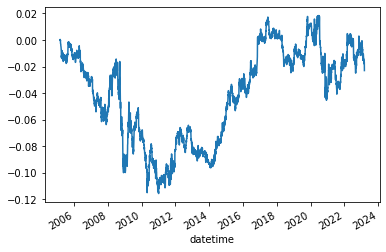

In [191]:
pnl = (SIGNAL.shift(1) *R).sum(1).replace({0:np.nan}).dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()
plt.show()

In [199]:
# ALPHA 28

In [268]:
# RSI
ups = pd.DataFrame(R[R>0].rolling(5,min_periods=1).mean().stack(),columns =['UPS'])
downs = pd.DataFrame(R[R<0].rolling(5,min_periods=1).mean().abs().stack(),columns =['DOWNS'])
RS = ups.join(downs)
RS.dropna()

UPS     DOWNS
datetime   Ticker                    
2005-01-05 AAP     0.001849  0.006659
           ABK     0.009963  0.013230
           ABS     0.001290  0.021053
           ACAS    0.014041  0.027609
           ADI     0.004520  0.027205
...                     ...       ...
2023-03-10 XRAY    0.013681  0.015219
           ZBH     0.006627  0.011514
           ZBRA    0.016250  0.021539
           ZION    0.005168  0.048879
           ZTS     0.009639  0.015795

[3060184 rows x 2 columns]

In [269]:
RS['ALPHA'] = RS['UPS'].divide(RS['DOWNS'],0)

In [270]:
RSI = 100 - (100/(1+RS['ALPHA']))
RSI = pd.DataFrame(RSI,dtype=float)
RSI

ALPHA
datetime   Ticker           
2005-01-04 AAPL          NaN
           AIG           NaN
           AN            NaN
           ANF           NaN
           ANSS          NaN
...                      ...
2023-03-10 XRAY    47.339069
           ZBH     36.530519
           ZBRA    43.001886
           ZION     9.562059
           ZTS     37.897612

[3194160 rows x 1 columns]

In [271]:
ALPHA = RSI['ALPHA'].unstack()[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
ALPHA = ALPHA.rolling(5,min_periods=1).rank(axis=0,pct=True,ascending=False)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\4070706341.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  ALPHA = ALPHA.rolling(5,min_periods=1).rank(axis=0,pct=True,ascending=False)


In [272]:

thresh =0.5

SIGNAL = ALPHA.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None

SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\1384291576.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)


0.5088427287919342


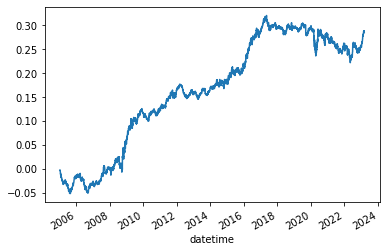

In [273]:
pnl = (SIGNAL.shift(1) *R).sum(1).replace({0:np.nan}).dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()
plt.show()